In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
#from os import listdir
import glob
import sncosmo
from ipywidgets import *
from sklearn.model_selection import train_test_split
from scipy.interpolate import (
    InterpolatedUnivariateSpline as Spline1d,
    RectBivariateSpline as Spline2d
)

%matplotlib inline

In [2]:
#kernel = 0.5 * (RBF(length_scale=20, length_scale_bounds=(7, 30)) + WhiteKernel(noise_level=0.1, noise_level_bounds=(1e-5,0.5)))

# Read the files

In [3]:
# file data paths
data_path = "./data/sp/"
file_names = glob.glob(data_path+"*.dat")
for i in range(0, len(file_names)):
    file_names[i] = file_names[i][10:]
print("Total files in path: ", len(file_names))

Total files in path:  2466


In [4]:
# auxiliar file 
sn_names = pd.read_csv("./data/list.dat",
                       header=None,
                       sep="\s+",
                       names=["name", "phase", "file_name"])
sn_names.head()

,name,phase,file_name
0,Test_SN0,-8.154,Test_SN0_0.dat
1,Test_SN0,-3.522,Test_SN0_1.dat
2,Test_SN0,17.959,Test_SN0_10.dat
3,Test_SN0,19.801,Test_SN0_11.dat
4,Test_SN0,19.816,Test_SN0_12.dat


In [5]:
names = sn_names["name"].unique()
print("Total number of sn files: ", len(names))

Total number of sn files:  171


# Training sample and simple graphs

In [6]:
w = widgets.Dropdown(
    options=names,
    value=names[0],
    description='SN name:',
    disabled=False,
)
display(w)

Dropdown(description='SN name:', options=('Test_SN0', 'Test_SN10', 'Test_SN11', 'Test_SN12', 'Test_SN13', 'Tes…

In [7]:
sn_spectra = glob.glob(data_path + w.value + "*.dat")

In [8]:
def spectra(i=0, plot=True):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    i = index of the element
    returns the wavelength, flux and flux error
    """
    if plot == True:
        data = sncosmo.read_lc(sn_spectra[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]
    else:
        data = sncosmo.read_lc(data_path+file_names[i], format="salt2")
        return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]


## Spectra

In [9]:
# option list for jupyter lab widgets
optionslist = []
for i in range(0, len(sn_spectra)):
    optionslist.append(i)

def update_graph(i):
    """
    void function that updates a matplotlib graph
    """
    wave, flux, fluxe = spectra(i)
    plt.xlabel("$\lambda$  ($\AA$)")
    plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)")
    plt.plot(wave, flux, "k")
    
i = widgets.Dropdown(options=optionslist, value=0, description='Index: ', disabled=False)

widgets.interactive(update_graph,i=i) # to activate the interactive widget

interactive(children=(Dropdown(description='Index: ', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 1…

## Monochromatic light curves

In [10]:
wave_number = 7000

time_lc = []
flux_lc = []

for i in range(0, len(sn_spectra)):
    wave, flux, fluxe = spectra(i)
    flux_lc.append(Spline1d(wave, flux,  k=1)(wave_number))
    time_lc.append(sn_names["phase"][sn_names["file_name"] == str(sn_spectra[i][10:])])

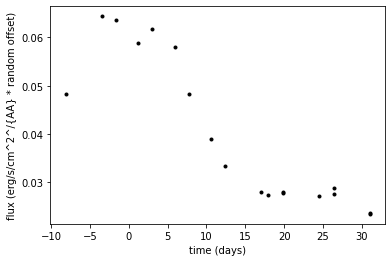

In [11]:
plt.plot(time_lc, flux_lc, "k.")
plt.xlabel("time (days)")
plt.ylabel("flux (erg/s/cm^2^/{AA} * random offset)");

## Training grid

In [12]:
"""
for i in range(0, len(file_names)):
    wave = spectra(i, plot=False)[0]
    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]
    plt.plot([phase,phase], [np.min(wave),np.max(wave)], 'k', linewidth=1)
    plt.xlabel("time (days)")
    plt.ylabel("$\lambda$ ($\AA$)")
    plt.xlim(-10, 50)
    plt.ylim(3500, 8500)
"""

'\nfor i in range(0, len(file_names)):\n    wave = spectra(i, plot=False)[0]\n    phase = sn_names["phase"][sn_names["file_name"] == str(file_names[i])]\n    plt.plot([phase,phase], [np.min(wave),np.max(wave)], \'k\', linewidth=1)\n    plt.xlabel("time (days)")\n    plt.ylabel("$\\lambda$ ($\\AA$)")\n    plt.xlim(-10, 50)\n    plt.ylim(3500, 8500)\n'

In [13]:
## Defining the grid
X_GRID = np.linspace(-10, 50, 61, dtype=int)
Y_GRID = np.linspace(3500, 8500, 501, dtype=int)

# Grid limits
print("time grid limits: ", np.min(X_GRID), ", ", np.max(X_GRID))
print("wavelenght grid limits: ", np.min(Y_GRID), ", ", np.max(Y_GRID))

time grid limits:  -10 ,  50
wavelenght grid limits:  3500 ,  8500


In [14]:
# split our data into a training and test dataset
np.random.seed(42)
sn_train, sn_test = train_test_split(names, test_size=0.2)
print(len(sn_train), len(sn_test))

136 35


In [15]:
def gaussian_process(wave, flux, error=True):
    """
    function that performs a gaussian process in a dataset of monochromatic light curves
    wave: Python list that gives the wavelenghts
    flux: np array that gives the flux
    error: binary variable to return or not the covariance in gaussian process regression
    
    return the corresponding gaussian process on data
    """
    # set the gaussian process regressor
    gp = GaussianProcessRegressor(kernel=kernel, alpha=0.0).fit(wave, flux)
    if error==True:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=True) # return mean and covariance
    else:
        return gp.predict(X_GRID[:, np.newaxis], return_cov=False) # return only mean     


In [16]:
def prepare_data_to_GP(wave):
    """
    function that convert a np array into a Python list for a gaussian process regression in SK-Learn
    wave: np array that gives the wavelenghts
    
    return the wavelenght in a correct format
    """
    temp_wave = [] # a new python list
    for ii in range(0, len(wave)):
        temp_wave.append([wave[ii]]) # correct SK-Learn format
    return temp_wave

In [17]:
def spectra_train(n_file):
    """
    function that returns the wavelenght, the flux and the flux error for a matplotlib graph or whatever spectra
    
    n_file: file name
    returns the wavelength, flux and flux error
    """
    data = sncosmo.read_lc(n_file, format="salt2")
    return data["WAVE"], data["SN_SPEC"], data["SN_ERR"]

In [18]:
SPEC_TRAIN_FUN = []
SPEC_TRAIN_TIME = []
SPEC_TRAIN_MINMAX = []
for i in range(0, len(sn_train)):
    SPEC_TRAIN_FUN.append([]) # for spectra function
    SPEC_TRAIN_TIME.append([]) # for spectra time
    SPEC_TRAIN_MINMAX.append([]) # for min max spectra (in wavelenghts)

In [19]:
for i in range(0, len(sn_train)):
    sn_train_spectra = glob.glob(data_path + sn_train[i] + "_*.dat")
    for j in range(0, len(sn_train_spectra)):
        wave, flux, eflux = spectra_train(sn_train_spectra[j]) # to get wave, flux and flux error
        SPEC_TRAIN_FUN[i].append(Spline1d(wave, flux)) # to register the corresponding function
        SPEC_TRAIN_TIME[i].append(np.float(sn_names["phase"][sn_names["file_name"] == str(sn_train_spectra[j][10:])])) # to regirster the corresponding spectra time
        SPEC_TRAIN_MINMAX[i].append([np.float(np.min(wave)), np.float(np.max(wave))]) # to register min and max wavelength that function is available

In [20]:
SPEC_GRID = []
for i in range(0, len(sn_train)):
    SPEC_GRID.append([]) # loop for each supernovae in training

In [21]:
for i in range(0, len(SPEC_GRID)):
    for j in range(0, len(Y_GRID)):
        SPEC_GRID[i].append([[], []]) # for each supernovae and for each wavelengh we fill with time and flux lists
#SPEC_GRID[0][1][0]  # first sn, second wave list order, time or flux

In [22]:
for i in range(0, len(sn_train)): # sn train index
    print(i+1, "/", len(sn_train))
    for j in range(0, len(Y_GRID)): #  grid index
        for k in range(0, len(SPEC_TRAIN_FUN[i])): #func index
            if SPEC_TRAIN_MINMAX[i][k][0] < Y_GRID[j] < SPEC_TRAIN_MINMAX[i][k][1]: # if it's inside the bounds
                SPEC_GRID[i][j][0].append(SPEC_TRAIN_TIME[i][k]) # time
                SPEC_GRID[i][j][1].append(np.float(SPEC_TRAIN_FUN[i][k](Y_GRID[j]))) # flux

1 / 136
2 / 136
3 / 136
4 / 136
5 / 136
6 / 136
7 / 136
8 / 136
9 / 136
10 / 136
11 / 136
12 / 136
13 / 136
14 / 136
15 / 136
16 / 136
17 / 136
18 / 136
19 / 136
20 / 136
21 / 136
22 / 136
23 / 136
24 / 136
25 / 136
26 / 136
27 / 136
28 / 136
29 / 136
30 / 136
31 / 136
32 / 136
33 / 136
34 / 136
35 / 136
36 / 136
37 / 136
38 / 136
39 / 136
40 / 136
41 / 136
42 / 136
43 / 136
44 / 136
45 / 136
46 / 136
47 / 136
48 / 136
49 / 136
50 / 136
51 / 136
52 / 136
53 / 136
54 / 136
55 / 136
56 / 136
57 / 136
58 / 136
59 / 136
60 / 136
61 / 136
62 / 136
63 / 136
64 / 136
65 / 136
66 / 136
67 / 136
68 / 136
69 / 136
70 / 136
71 / 136
72 / 136
73 / 136
74 / 136
75 / 136
76 / 136
77 / 136
78 / 136
79 / 136
80 / 136
81 / 136
82 / 136
83 / 136
84 / 136
85 / 136
86 / 136
87 / 136
88 / 136
89 / 136
90 / 136
91 / 136
92 / 136
93 / 136
94 / 136
95 / 136
96 / 136
97 / 136
98 / 136
99 / 136
100 / 136
101 / 136
102 / 136
103 / 136
104 / 136
105 / 136
106 / 136
107 / 136
108 / 136
109 / 136
110 / 136
111 / 13